In [105]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [23]:
label = torch.tensor([1, 2, 3, 4, 5,2,2,2,2,2,2,2,2,2,2,2,2,])
label

tensor([1, 2, 3, 4, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [24]:
mask = (label != 0)
mask

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True])

In [25]:
label[mask]

tensor([2, 3, 4, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [33]:
torch.histc(label[mask].float(), bins=6, min=0, max=5)

tensor([ 0.,  0., 13.,  1.,  1.,  1.])

In [34]:
import math
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F


class Morphology(nn.Module):
    '''
    Base class for morpholigical operators 
    For now, only supports stride=1, dilation=1, kernel_size H==W, and padding='same'.
    '''
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        '''
        in_channels: scalar
        out_channels: scalar, the number of the morphological neure. 
        kernel_size: scalar, the spatial size of the morphological neure.
        soft_max: bool, using the soft max rather the torch.max(), ref: Dense Morphological Networks: An Universal Function Approximator (Mondal et al. (2019)).
        beta: scalar, used by soft_max.
        type: str, dilation2d or erosion2d.
        '''
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)
        self.unfold = nn.Unfold(kernel_size, dilation=0, padding=0, stride=0)

    def forward(self, x):
        '''
        x: tensor of shape (B,C,H,W)
        '''
        # padding
        x = fixed_padding(x, self.kernel_size, dilation=1)
        
        # unfold
        x = self.unfold(x)  # (B, Cin*kH*kW, L), where L is the numbers of patches
        x = x.unsqueeze(1)  # (B, 1, Cin*kH*kW, L)
        L = x.size(-1)
        L_sqrt = int(math.sqrt(L))

        # erosion
        weight = self.weight.view(self.out_channels, -1) # (Cout, Cin*kH*kW)
        weight = weight.unsqueeze(0).unsqueeze(-1)  # (1, Cout, Cin*kH*kW, 1)

        if self.type == 'erosion2d':
            x = weight - x # (B, Cout, Cin*kH*kW, L)
        elif self.type == 'dilation2d':
            x = weight + x # (B, Cout, Cin*kH*kW, L)
        else:
            raise ValueError
        
        if not self.soft_max:
            x, _ = torch.max(x, dim=2, keepdim=False) # (B, Cout, L)
        else:
            x = torch.logsumexp(x*self.beta, dim=2, keepdim=False) / self.beta # (B, Cout, L)

        if self.type == 'erosion2d':
            x = -1 * x

        # instead of fold, we use view to avoid copy
        x = x.view(-1, self.out_channels, L_sqrt, L_sqrt)  # (B, Cout, L/2, L/2)

        return x 

class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')

class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')



def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs

In [ ]:
# Using pytorch, implement a morphological dilation operator with a 3x3 kernel and a dilation rate of 2
# The input image is a 1x1x10x10 tensor of integers between 0 and 255
# The output image should be a 1x1x10x10 tensor of integers between 0 and 255

import torch
import torch.nn as nn
import torch.nn.functional as F

def dilate(image, kernel_size, dilation_rate):
    # Check if input is a 4D tensor (batched image)
    if len(image.shape) != 4:
        raise ValueError("Input image should be a 4D tensor")

    # Expand the input tensor using unfold
    unfolded_image = F.unfold(image, kernel_size, padding=dilation_rate * (kernel_size[0] - 1), stride=1)

    # Create a tensor to store the dilated image
    dilated_image = torch.zeros_like(image)

    # Apply pointwise maximum operations to combine the expanded elements with the original ones
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            dilated_image[i, j] = torch.max(unfolded_image[i, j, :, :], image[i, j])

    return dilated_image

Thanks to : https://stackoverflow.com/questions/56235733/is-there-a-tensor-operation-or-function-in-pytorch-that-works-like-cv2-dilate

In [47]:
im = np.array([ [0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 1, 1, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0] ], dtype=np.int8)
kernel_el = np.array([ [0, 1, 0],
                    [1, 1, 1],
                    [0, 1, 0] ], dtype=np.int8)

In [61]:
im = np.array([ [0, -10, 0, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 1, 1, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0] ], dtype=np.int8)
kernel_el = np.array([ [0, 1, 0],
                    [1, 1, 1],
                    [0, 1, 0] ], dtype=np.int8)
im_tensor = torch.Tensor(np.expand_dims(np.expand_dims(im, 0), 0)) # size:(1, 1, 5, 5)
kernel_tensor = torch.Tensor(np.expand_dims(np.expand_dims(kernel_el, 0), 0)) # size: (1, 1, 3, 3)
torch_result = torch.clamp(torch.nn.functional.conv2d(im_tensor, kernel_tensor, padding=(1, 1)), 0, 1)
print(torch_result)

tensor([[[[0., 0., 0., 0., 0.],
          [1., 0., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [0., 1., 1., 1., 1.],
          [0., 0., 0., 1., 0.]]]])


In [49]:
np.expand_dims(np.expand_dims(im, 0), 0).shape

(1, 1, 5, 5)

In [111]:
torch.nn.functional.conv2d(im_tensor, kernel_tensor, padding=(1, 1))

tensor([[[[-10.,  -9., -10.,   0.,   0.],
          [  1.,  -8.,   2.,   0.,   0.],
          [  1.,   3.,   2.,   2.,   0.],
          [  0.,   1.,   2.,   1.,   1.],
          [  0.,   0.,   0.,   1.,   0.]]]])

In [57]:


tensor = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
mask = torch.tensor([[1, 1, 1], [1, 0, 1], [1, 1, 1]], dtype=torch.bool)

masked_tensor = torch.masked_fill(tensor, mask, 0)
# masked_tensor = torch.masked_fill(tensor, ~mask, 0)

print(masked_tensor)


tensor([[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]])


In [167]:
tensor = torch.tensor([[1, 1, 1], [0, 7, 0], [3, 4, 5]], dtype=torch.long)

In [168]:
one_hot = torch.nn.functional.one_hot(tensor)
print(one_hot)

tensor([[[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]]])


In [164]:
# Change one_hot shape from (H, W, C) to (C, H, W)
one_hot = one_hot.permute(2, 0, 1)
print(one_hot)

tensor([[[0, 0, 0],
         [1, 0, 1],
         [0, 0, 0]],

        [[1, 1, 1],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [1, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 1]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 1, 0],
         [0, 0, 0]]])


In [169]:
# from one-hot encoding to label index
torch.argmax(one_hot, dim=-1)

tensor([[1, 1, 1],
        [0, 7, 0],
        [3, 4, 5]])

In [786]:
# tensor = torch.tensor([[0,0,0,0,0],[0,0,0,3,0],[0,0,0,0,0],[0,2,0,0,0],[0,0,0,0,0]]).to(torch.long)
i = 20
tensor = torch.zeros((i,i)).to(torch.long)
shift = 5
tensor[shift+1, -1 - shift+1] = 3
print((shift + 10, -1 - shift))
tensor[-1 - shift, shift] = 2
print((-1 - shift, shift))
# tensor = torch.tensor([[1,1,1,1,1],[1,0,2,0,1],[1,2,2,2,1],[1,0,2,0,1],[1,1,1,1,1]]).to(torch.long)
# tensor = torch.tensor([[0,0,0,0,0],[0,0,2,0,0],[0,2,2,2,0],[0,0,2,0,0],[0,0,0,0,0]]).to(torch.long)
print('tensor :')
print(tensor)
print(tensor.shape)

one_hot_tensor = torch.nn.functional.one_hot(tensor)
print('one_hot_tensor :')
print(one_hot_tensor)
print(one_hot_tensor.shape)

one_hot_tensor = one_hot_tensor.permute(2, 0, 1)
print('one_hot_tensor :')
print(one_hot_tensor)
print(one_hot_tensor.shape)
print(one_hot_tensor.dtype)

(15, -6)
(-6, 5)
tensor :
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

kernel element :
tensor([[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]])
torch.Size([3, 3])
kernel :
tensor([[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
    

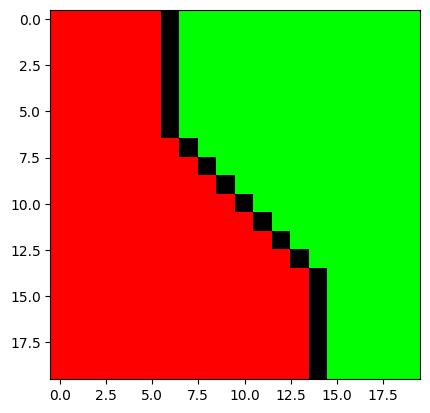

In [805]:


# one_hot_tensor = one_hot_tensor.unsqueeze(0)

# Create a kernel such that the output of the convolution is the same as the input one_hot_tensor
kernel_el = torch.tensor([[0,0,0],[0,1,0],[0,0,0]]).to(torch.long)
print('kernel element :')
print(kernel_el)
print(kernel_el.shape)

# Create a kernel with size (C, C, H, W) where C is the number of classes, H, W are the kernel size and each element of [C,C,:] is the kernel_el
kernel = torch.zeros((one_hot_tensor.shape[0], one_hot_tensor.shape[0], kernel_el.shape[0], kernel_el.shape[1])).to(torch.long)
print('kernel :')
print(kernel)
print(kernel.shape)

# Fill the kernel with the kernel_el
for i in range(kernel.shape[0]):
    for j in range(kernel.shape[1]):
        if i == j:
            kernel[i, j] = kernel_el
        else:
            kernel[i, j] = torch.zeros_like(kernel_el)

kernel[2,2] = torch.tensor([[0,1,0],[1,100,1],[0,1,0]]).to(torch.long) # kernel for class 2, its the kernel for dilation
kernel[2,1] = torch.tensor([[0,0,0],[0,-10,0],[0,0,0]]).to(torch.long) # kernel for class 2, its a negative dilation such that if class 1 is in the neighborhood, the result will be 0 and not 1, thus class 1 act as an obstacle
kernel[2,3] = torch.tensor([[0,-10,0],[-10,-10,-10],[0,-10,0]]).to(torch.long) # kernel for class 2, its a negative dilation such that if class 3 is in the neighborhood, the result will be 0 and not 1, thus class 3 act as an obstacle

kernel[3,3] = torch.tensor([[0,1,0],[1,100,1],[0,1,0]]).to(torch.long) # kernel for class 3, its the kernel for dilation
kernel[3,1] = torch.tensor([[0,0,0],[0,-10,0],[0,0,0]]).to(torch.long) # kernel for class 3, its a negative dilation such that if class 1 is in the neighborhood, the result will be 0 and not 1, thus class 1 act as an obstacle
kernel[3,2] = torch.tensor([[0,-10,0],[-10,-10,-10],[0,-10,0]]).to(torch.long) # kernel for class 3, its a negative dilation such that if class 2 is in the neighborhood, the result will be 0 and not 1, thus class 2 act as an obstacle

print('kernel :')
print(kernel)
print(kernel.shape)
print(kernel.dtype)

# Convolve the one_hot_tensor with the kernel
print('cond dtype :')
print(torch.nn.functional.conv2d(one_hot_tensor, kernel, padding='same').dtype)
one_hot_tensor = torch.nn.functional.conv2d(one_hot_tensor, kernel, padding='same')
print('one_hot_tensor after convolution :')
print(one_hot_tensor)
print(one_hot_tensor.shape)

print('one_hot_tensor after clamping :')
one_hot_tensor = torch.clamp(one_hot_tensor, 0, 1)
print(one_hot_tensor)
print(one_hot_tensor.shape)

one_hot_tensor_copy = one_hot_tensor.clone()

# Set first channel to zero to not be taken into account by the argmax
one_hot_tensor_copy[0] = torch.zeros_like(one_hot_tensor_copy[0])

# from one-hot encoding to label index
tensor = torch.argmax(one_hot_tensor_copy, dim=0)
print('tensor (one_hot_tensor after argmax) :')
print(tensor)
print(tensor.shape)

palette = [[0, 0, 0], [255, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [128, 0, 0], [0, 128, 0], [0, 0, 128], [64, 64, 64], [128, 128, 0], [128, 0, 128], [0, 128, 128], [255, 128, 0], [192, 192, 192], [128, 128, 128]]

tensor = tensor.squeeze()

# Assert the tensor shape is 2D
assert tensor.dim() == 2

# from tensor to numpy array uint8
img = tensor.cpu().numpy()
img = np.uint8(img)
print(img)
img = Image.fromarray(img).convert('P')
img.putpalette(np.array(palette, dtype=np.uint8))

plt.imshow(np.array(img.convert('RGB')))

[[0 0 0 ... 0 3 0]
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 0 3 0]
 ...
 [0 2 0 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [0 2 0 ... 0 0 0]]


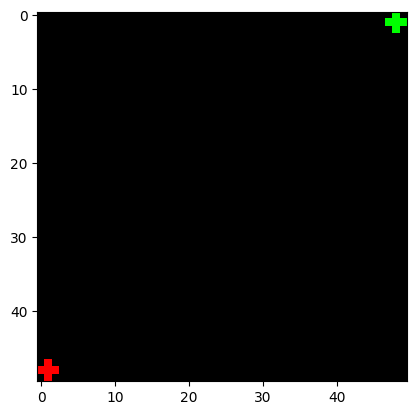

In [247]:
palette = [[0, 0, 0], [255, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [128, 0, 0], [0, 128, 0], [0, 0, 128], [64, 64, 64], [128, 128, 0], [128, 0, 128], [0, 128, 128], [255, 128, 0], [192, 192, 192], [128, 128, 128]]

tensor = tensor.squeeze()

# Assert the tensor shape is 2D
assert tensor.dim() == 2

# from tensor to numpy array uint8
img = tensor.cpu().numpy()
img = np.uint8(img)
print(img)
img = Image.fromarray(img).convert('P')
img.putpalette(np.array(palette, dtype=np.uint8))

plt.imshow(np.array(img.convert('RGB')))